In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acovf, acf, pacf
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

In [3]:
def t_student_tests(data):
    # Parametry dla rozkładu t-Studenta
    d_f, loc, sc = st.t.fit(data)
    print(d_f, loc, sc)
    # Test t-Studenta dla średniej
    t_stat, t_p_value = st.ttest_1samp(data, popmean=loc)
    
    # Test Kolmogorova-Smirnova z rozkładem t-Studenta
    ks_stat, ks_p_value = st.kstest(data, st.t(d_f, loc, sc).cdf)
    
    # Interpretacja wyników
    print("Test t-Studenta:")
    print(f"Statystyka t: {t_stat:.4f}, p-wartość: {t_p_value:.4f}")
    print("Wynik testu t-Studenta:")
    if t_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: średnia próby różni się od zadanej wartości.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.")
    
    print("\nTest Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu t-Studenta.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


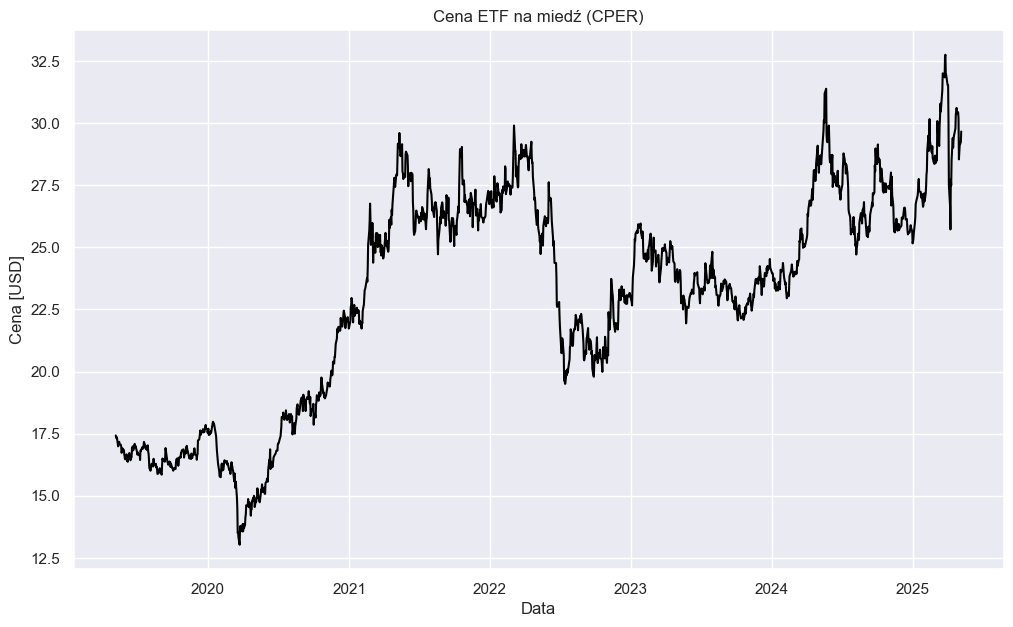

In [4]:
copper = yf.download('CPER', period='6y')['Close']

plt.plot(copper, color = 'black')
plt.title('Cena ETF na miedź (CPER)')
plt.ylabel('Cena [USD]')
plt.xlabel('Data')
plt.grid(True)
plt.show()

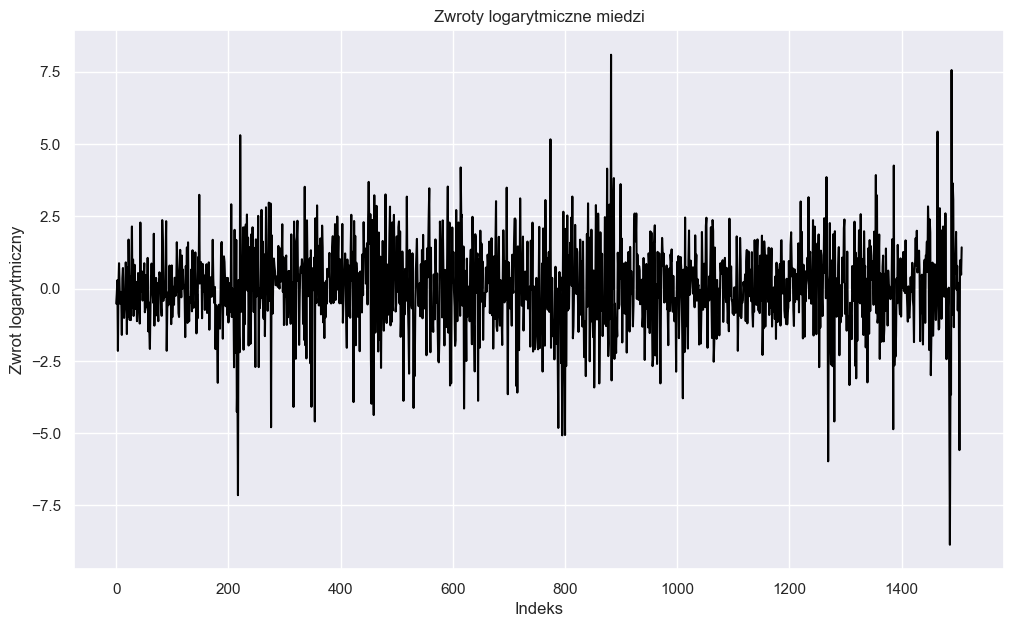

In [5]:
log_returns_copper = np.log(copper / copper.shift(1)).dropna()
log_returns_copper = 100*np.ravel(log_returns_copper)
plt.plot(log_returns_copper, color = 'black')
plt.title('Zwroty logarytmiczne miedzi')
plt.ylabel('Zwrot logarytmiczny')
plt.xlabel('Indeks')
plt.grid(True)
plt.show()

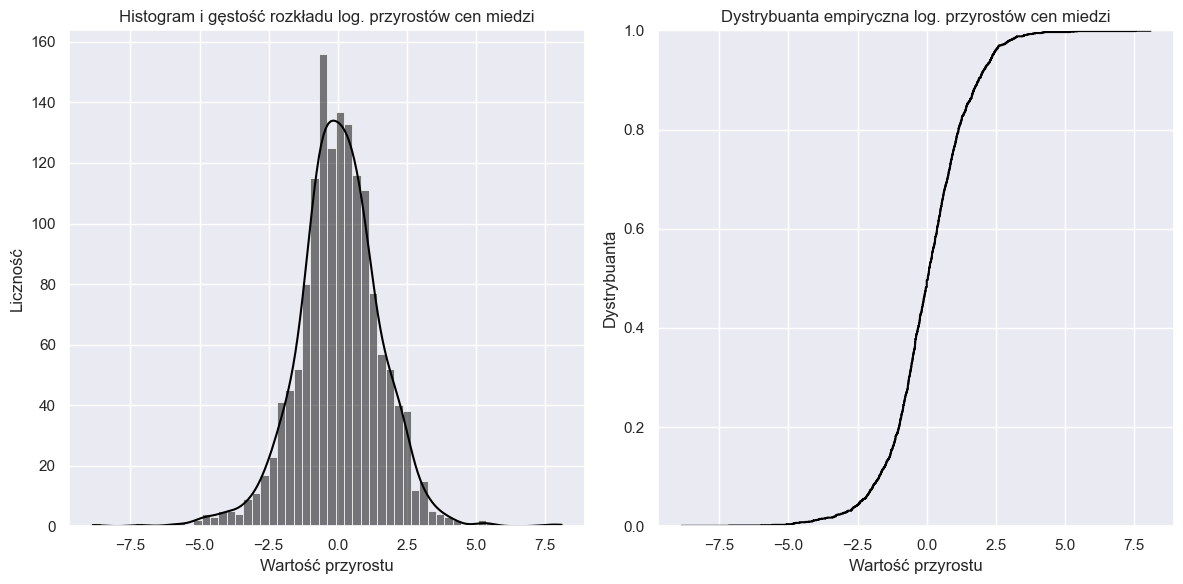

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram i gęstość rozkładu na pierwszym subplocie
sns.histplot(log_returns_copper, kde=True, ax=axes[0], color = 'black')
axes[0].set_title('Histogram i gęstość rozkładu log. przyrostów cen miedzi')
axes[0].set_xlabel('Wartość przyrostu')
axes[0].set_ylabel('Liczność')

# Dystrybuanta empiryczna na drugim subplocie
sns.ecdfplot(log_returns_copper, ax=axes[1], color = 'black')
axes[1].set_title('Dystrybuanta empiryczna log. przyrostów cen miedzi')
axes[1].set_xlabel('Wartość przyrostu')
axes[1].set_ylabel('Dystrybuanta')

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()

In [21]:
t_student_tests(log_returns_copper)
d_f, loc, sc = st.t.fit(log_returns_copper)
d_f = 6

5.913086831177374 0.05154486720744103 1.2223017369219935
Test t-Studenta:
Statystyka t: -0.4207, p-wartość: 0.6741
Wynik testu t-Studenta:
Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.

Test Kolmogorova-Smirnova:
Statystyka: 0.0174, p-wartość: 0.7448
Wynik testu Kolmogorova-Smirnova:
Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.


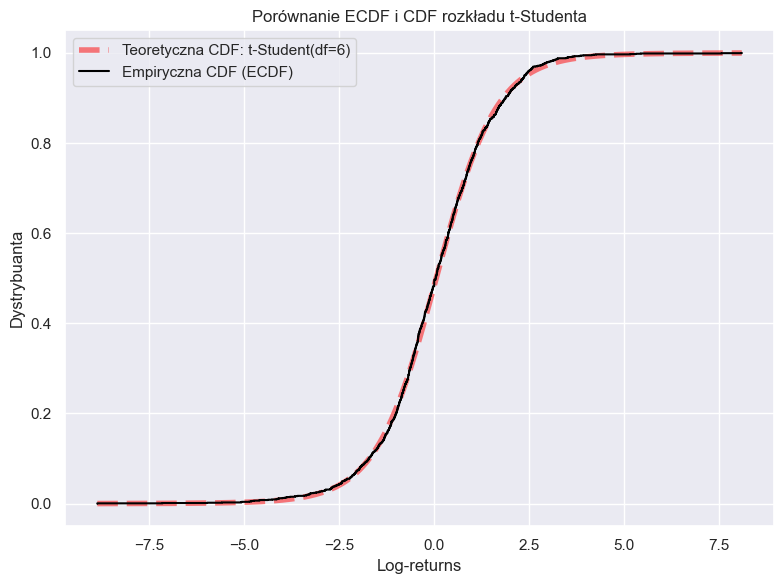

In [22]:
ecdf = ECDF(log_returns_copper)

# Siatka do wykresu
x = np.linspace(min(log_returns_copper), max(log_returns_copper), 1000)
t_cdf = st.t.cdf(x, df=d_f, loc=loc, scale=sc)

# Wykres
plt.figure(figsize=(8, 6))
plt.plot(x, t_cdf, label=f'Teoretyczna CDF: t-Student(df={d_f})', color='red', linewidth=4, alpha=0.5, linestyle='dashed')
plt.step(ecdf.x, ecdf.y, label='Empiryczna CDF (ECDF)', where='post', color='black')
plt.title('Porównanie ECDF i CDF rozkładu t-Studenta')
plt.xlabel('Log-returns')
plt.ylabel('Dystrybuanta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ZADANIE 1

## a)

Wersja chatowa :D

In [8]:
def var_parametric(series, alpha, dist='t', positive=True):
    """
    Parametric (rolling) daily VaR.
    positive=True  ➜ zwraca dodatnią liczbę straty
    positive=False ➜ zwraca wartość kwantyla (zwykle ujemną)
    """
    if dist == 't':
        df, loc, scale = st.t.fit(series)
        q = st.t.ppf(1 - alpha, df)          # lewy ogon (np. 0.05)   
        var = loc + scale * q
    else:
        mu, sigma = st.norm.fit(series)
        q = st.norm.ppf(1 - alpha)           
        var = mu + sigma * q
    return abs(var) if positive else var

In [9]:
var_parametric(log_returns_copper, 0.95), var_parametric(log_returns_copper, 0.99)

(2.329874634367004, 3.8087269037028175)

Wersja kingi

In [10]:
#Var95
var_95_1 = st.t(d_f, loc, sc).ppf(0.95)
#Var99
var_99_1 = st.t(d_f, loc, sc).ppf(0.99)

In [11]:
var_95_1, var_99_1

(2.4266974992338617, 3.8928339151198803)

Poprawiona funkcja plot

In [12]:
def plot_var(values, VaR95, VaR99, title='Zwroty'):
    values = pd.Series(values)   # bezpieczne rzutowanie
    plt.figure(figsize=(16, 8))
    plt.plot(values.index, values, 'o', markersize=3, label='Zwrot')
    plt.title(title, fontsize=18)
    plt.xlabel('Obserwacja')
    plt.ylabel('Wartość')
    
    # kwantyle empiryczne
    Q95, Q99 = np.quantile(values, [0.95, 0.99])
    plt.axhline(Q95, color='k', lw=2, label=f'Q95 emp. = {Q95:.2f}')
    plt.axhline(Q99, color='brown', lw=2, label=f'Q99 emp. = {Q99:.2f}')
    
    # VaR – zakładamy, że podajesz dodatnią liczbę straty
    plt.axhline(-VaR95, color='k', ls='--', lw=2, label=f'VaR95 = {VaR95:.2f}')
    plt.axhline(-VaR99, color='brown', ls='--', lw=2, label=f'VaR99 = {VaR99:.2f}')
    
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


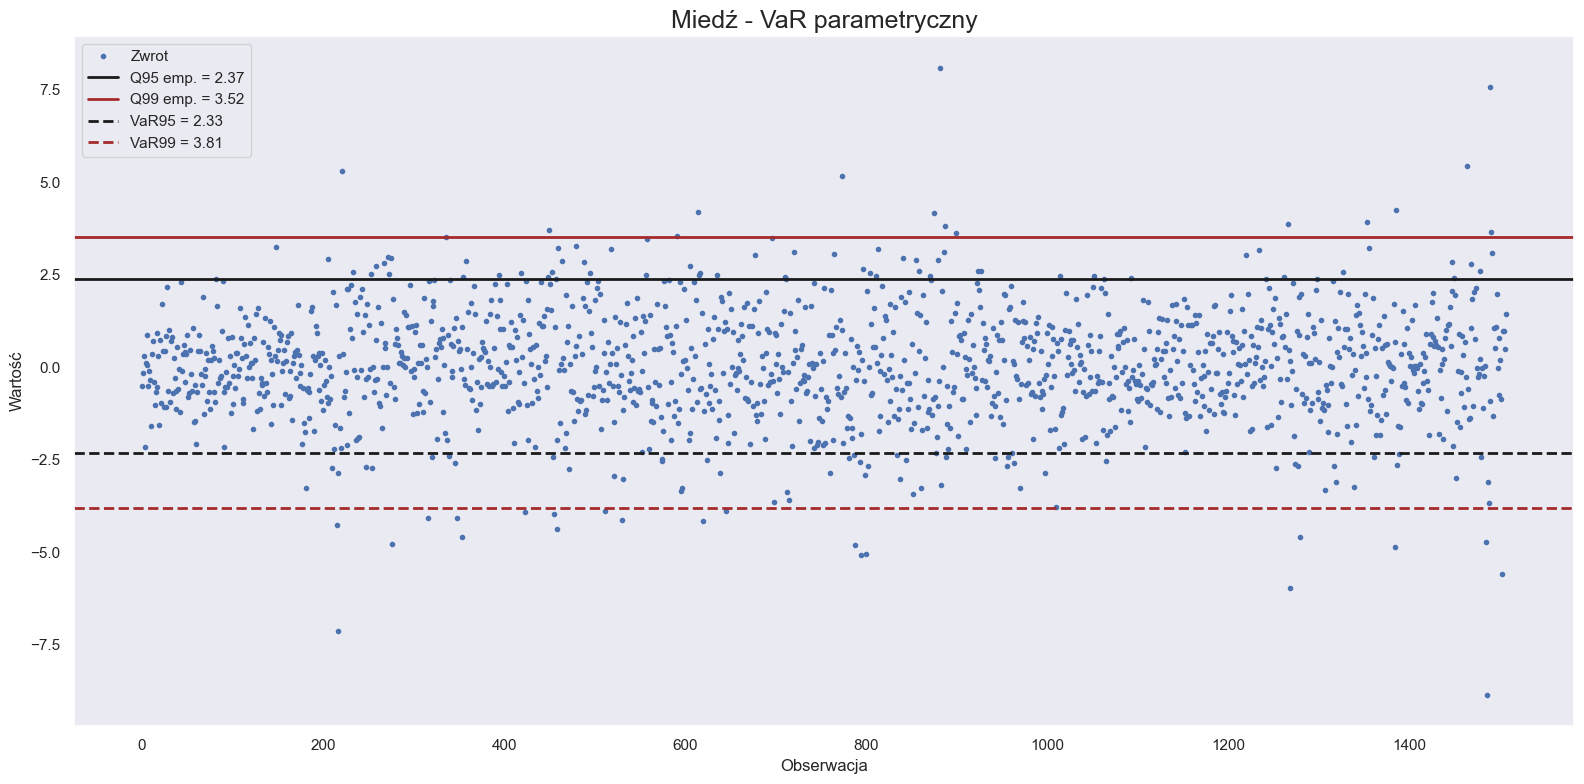

In [13]:
# kwantyle lewego ogona
VaR95 = var_parametric(log_returns_copper, 0.95, positive=True)
VaR99 = var_parametric(log_returns_copper, 0.99, positive=True)

plot_var(log_returns_copper, VaR95, VaR99,
         title='Miedź - VaR parametryczny')


Dlaczego empiryczny Q95 (2.37) ≠ parametryczny VaR95 (2.33)?

Empiryka bierze 5 % skrajnych danych (historia).

Parametryka używa wzoru t‑Studenta – lekko odmienny kształt ogona → delikatnie niższy VaR. Różnica kilkusetetnych % jest naturalna.

## b) 
#### i)

Mając próbkę zwrotów $(R_1, R_2, \ldots, R_t)$, obliczamy empiryczny kwantyl na poziomie $1 - \alpha$ (ozn. $q_{1-\alpha}$), to znaczy taki punkt, poniżej którego znajduje się $(1 - \alpha)\%$ obserwacji zwrotów. Wtedy wartość zagrożona (Value at Risk) przy poziomie ufności $\alpha$ wyraża się wzorem:

$$
VaR_\alpha = -q_{1-\alpha}
$$

gdzie znak minus oznacza, że VaR jest wyrażony jako dodatnia liczba odpowiadająca potencjalnej stracie (ujemnemu zwrotowi).

W praktyce obliczyliśmy:

* $VaR_{95\%} = -q_{5\%}$ 
* $VaR_{99\%} = -q_{1\%}$ 



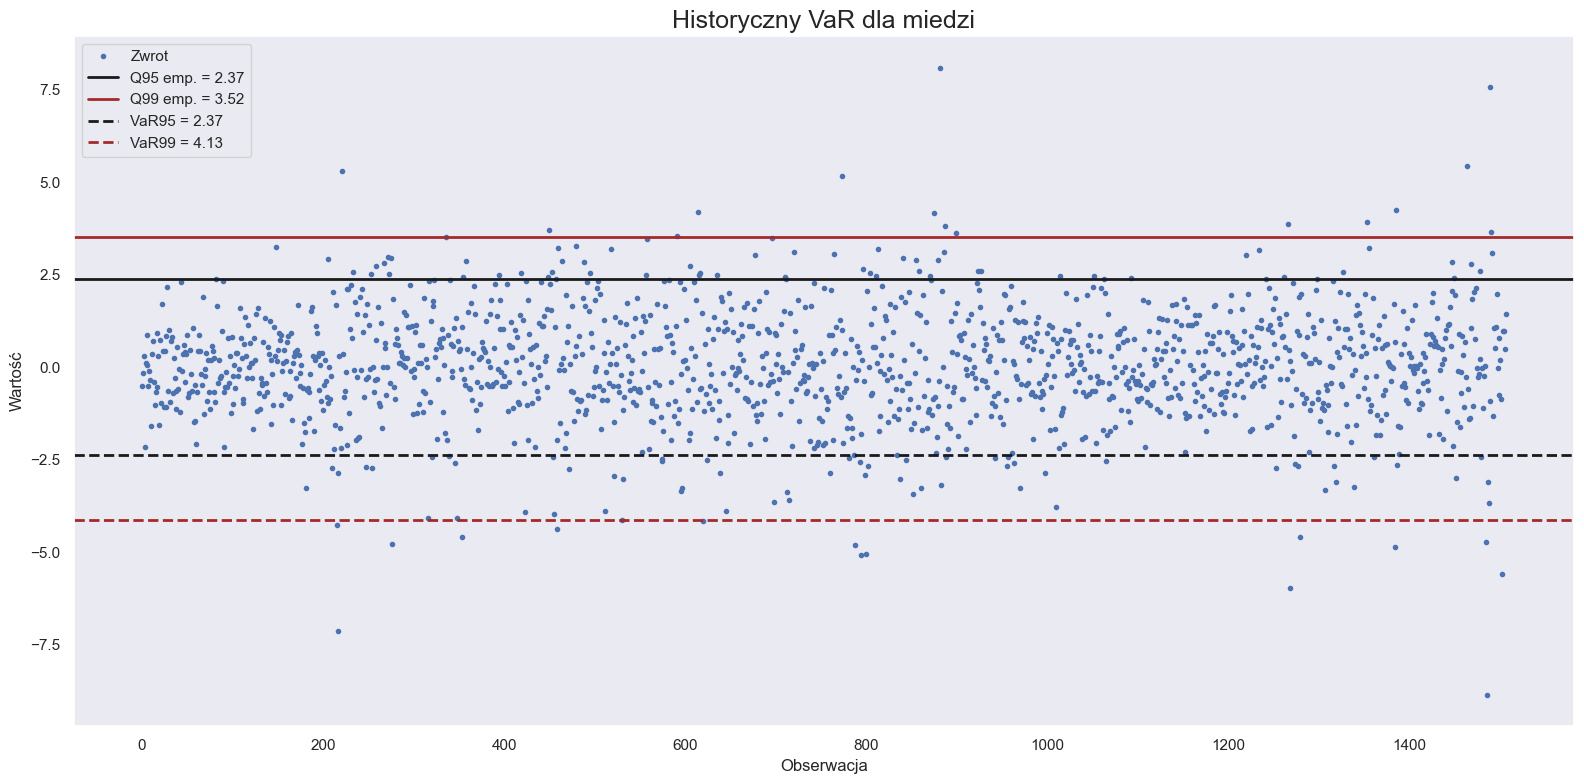

In [14]:
VaR95 = -np.quantile(log_returns_copper, 0.05)
VaR99 = -np.quantile(log_returns_copper, 0.01)

plot_var(log_returns_copper, VaR95, VaR99, title='Historyczny VaR dla miedzi')

#### ii)

#### iii)

## c)

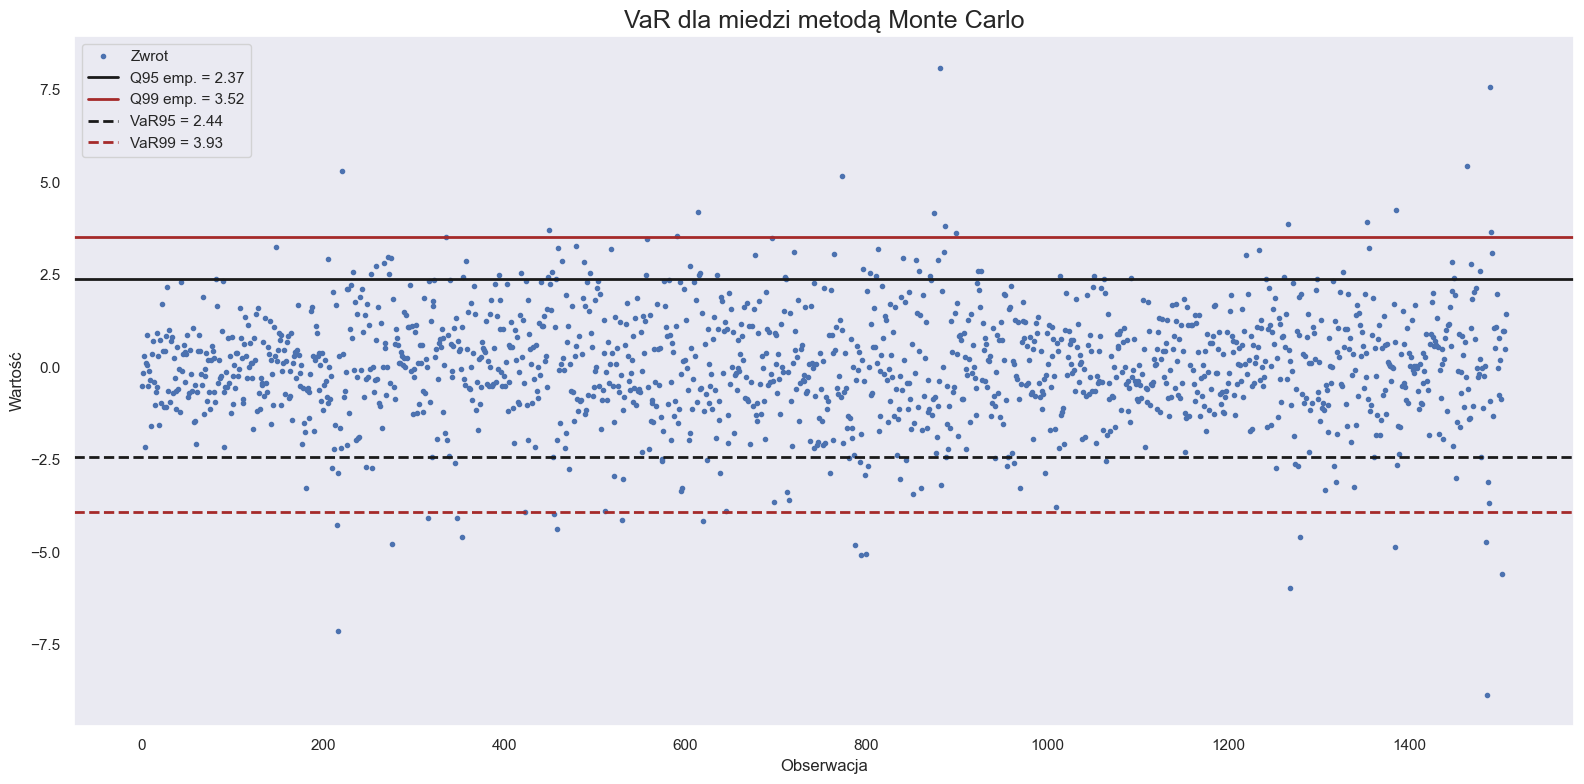

In [41]:
d_f, loc, sc = st.t.fit(log_returns_copper)
d_f = 6

simulated_returns = st.t.rvs(d_f, loc=loc, scale=sc, size=100000, random_state=1)

VaR95 = np.quantile(simulated_returns, 0.95)
VaR99 = np.quantile(simulated_returns, 0.99)

plot_var(log_returns_copper, VaR95, VaR99, title='VaR dla miedzi metodą Monte Carlo')

# Zadanie 2

In [60]:
def backtesting(alpha, data, method, *method_parameters):
    n = len(data) // 2
    results = np.zeros(n)
    data = np.array(data)
    for i in range(n):
        VaR = method(data[i:n + i], alpha, *method_parameters)
        results[i] = int(data[n + i] < VaR)
    return results

# a)

In [61]:
a_wektor_przekroczen_95 = backtesting(0.95, log_returns_copper, var_parametric)
a_wektor_przekroczen_99 = backtesting(0.99, log_returns_copper, var_parametric)


print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(a_wektor_przekroczen_99))
print("0.95:", np.mean(a_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(a_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(a_wektor_przekroczen_95, ddof=1))

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9893899204244032
0.95: 0.9562334217506632

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.010511446697736024
0.0475: 0.04190664398110475


## b)
#### i)

In [66]:
def var_historical(data, alpha):
    VaR = -np.quantile(data, (1 - alpha))
    return VaR

b1_wektor_przekroczen_95 = backtesting(0.95, log_returns_copper, var_historical)
b1_wektor_przekroczen_99 = backtesting(0.99, log_returns_copper, var_historical)

print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(b1_wektor_przekroczen_99))
print("0.95:", np.mean(b1_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(b1_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(b1_wektor_przekroczen_95, ddof=1))


Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9907161803713528
0.95: 0.9562334217506632

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.00920984497025162
0.0475: 0.04190664398110475


#### ii)

#### iii)

## c)

In [58]:
def backtesting(alpha, data):
    n = len(data) // 2
    results = np.zeros(n)
    data = np.array(data)
    d_f, loc, sc = st.t.fit(data)
    d_f = 6  

    simulated_returns = st.t.rvs(d_f, loc=loc, scale=sc, size=100000, random_state=1)
    
    for i in range(n):
        VaR = -np.percentile(simulated_returns, (1 - alpha) * 100)
        results[i] = int(data[n + i] < VaR)
    
    return results

c_wektor_przekroczen_95 = backtesting(0.95, log_returns_copper)
c_wektor_przekroczen_99 = backtesting(0.99, log_returns_copper)

# Obliczenia wyników
print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(c_wektor_przekroczen_99))
print("0.95:", np.mean(c_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(c_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(c_wektor_przekroczen_95, ddof=1))

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9880636604774535
0.95: 0.9442970822281167

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.01180952582243968
0.0475: 0.05266995677766389
